Studying Ptolemy's sun declination using visualization tools
----

In [1]:
from kanon.units import Sexagesimal
from kanon.units.precision import set_precision, TruncatureMode
from kanon.tables import HTable
import math
from astropy.units import arcsecond
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# This function redefines what is in the declination notebook

def build_declination(sin_table, obliquity):
    arcsin_table = sin_table.copy(set_index="Val")
    obl = sin_table.get(obliquity)
    obl_table = sin_table.apply("Val", lambda x: x * obl)
    return obl_table.apply("Val", lambda x: round(arcsin_table.get(x), 2))

In [3]:
OBLIQUITY = "23;51,20"

In [4]:
sin = lambda x: math.sin(x * math.pi / 180)
asin = lambda x: math.asin(x) * 180 / math.pi

# This table holds computed sine values
sin_table_true = HTable([
    list(Sexagesimal.range(0, 91)),
    [round(
        Sexagesimal.from_float(sin(x), 3)
    ) for x in range(0, 91)]
], names=("Arg", "Val"), index="Arg")

# This table holds computed declination values
decl_table_true = HTable([
    list(Sexagesimal.range(1, 91)),
    [round(Sexagesimal.from_float(
        asin(sin(x) * sin(Sexagesimal(OBLIQUITY))
    ), 2)) for x in range(1, 91)]
], names=("Arg", "Val"), index="Arg")

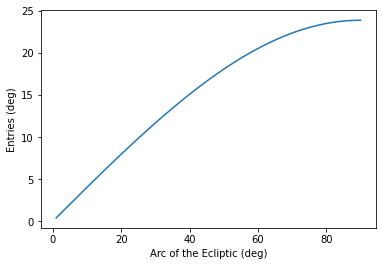

In [5]:
# We import Ptolemy's sun declination table from DISHAS
ptolemy_decl = HTable.read(214, format="dishas")

ptolemy_decl.plot2d()
plt.show()

In [6]:
# We rebuild a declination table from a sine table without odd arguments

sin_table_grid2 = sin_table_true[[i for i in range(0, 91, 2)]]
decl_table_grid2 = build_declination(sin_table_grid2, Sexagesimal(OBLIQUITY))[1:]

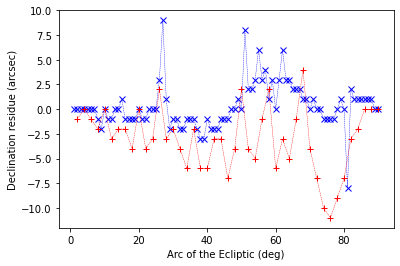

In [7]:
# Let's compare Ptolemy's declination with our reconstructed tables

residue_nogrid = ptolemy_decl.apply("Entries", lambda x: x - decl_table_true["Val"], "Declination residue")
residue_nogrid["Declination residue"] = residue_nogrid["Declination residue"].to(arcsecond)
# For the computed declination table residue, we plot in blue
residue_nogrid.plot2d('bx', linestyle='dashed', lw=0.4)

residue_grid2 = ptolemy_decl[[i for i in range(1,91,2)]].apply("Entries", lambda x: x - decl_table_grid2["Val"], "Declination residue")
residue_grid2["Declination residue"] = residue_grid2["Declination residue"].to(arcsecond)
# For the built declination with grid 2 sine residue, we plot in red
residue_grid2.plot2d('r+', linestyle='dashed', lw=0.4)

plt.show()

In [8]:
arr_nogrid = residue_nogrid['Declination residue']
arr_grid2 = residue_grid2['Declination residue']

print("Residue with no interpolation")
print(f"mean : {np.mean(arr_nogrid)}, std : {round(np.std(arr_nogrid))}")
print(f"quartiles : {np.quantile(arr_nogrid, [0.25, 0.5, 0.75])} \n")
print("Residue with grid 2 interpolation")
print(f"mean : {np.mean(arr_grid2)}, std : {round(np.std(arr_grid2))}")
print(f"quartiles : {np.quantile(arr_grid2, [0.25, 0.5, 0.75])}")

Residue with no interpolation
mean : 00 ; 18,40, std : 02 ; 15,50
quartiles : [-01 ; 00,00 00 ; 00,00 01 ; 00,00] 

Residue with grid 2 interpolation
mean : -03 ; 01,20, std : 03 ; 09,06
quartiles : [-05 ; 00,00 -03 ; 00,00 -01 ; 00,00]
